In [92]:
import io

import numpy as np
import pandas as pd

import keras

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [94]:
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBRegressor

In [95]:
dataset_DiagnRatios = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/DiagnRatios.csv")
dataset_EmisionLines = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/EmissionLines.csv")
dataset_OutPar = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/OutPar.csv")
dataset_rion_rout = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/rion_rout.csv")

In [96]:
merged_df_EmDiag = pd.merge(dataset_EmisionLines, dataset_DiagnRatios, on='id', how='inner')  # Inner join

In [97]:
num_rows_without_na = dataset_EmisionLines.dropna().shape
print(num_rows_without_na)

(0, 25)


In [98]:
for col in dataset_EmisionLines.columns:
    print(f"Column '{col}' has {dataset_EmisionLines[col].isna().sum()} missing values")

Column 'id' has 0 missing values
Column 'he_1_3889a' has 648325 missing values
Column 'he_1_4026a' has 50015 missing values
Column 'he_1_4471a' has 40209 missing values
Column 'he_1_5876a' has 41457 missing values
Column 'n_2_6584a' has 644613 missing values
Column 'he_1_6678a' has 41457 missing values
Column 'he_1_7065a' has 41459 missing values
Column 'he_2_4686a' has 40927 missing values
Column 'o_1_6300a' has 290145 missing values
Column 'o_1_6363a' has 644613 missing values
Column 'o_3_4959a' has 258971 missing values
Column 'o_3_5007a' has 263867 missing values
Column 's_3_6312a' has 341937 missing values
Column 's_ii_4070a' has 644613 missing values
Column 's_ii_6716a' has 347984 missing values
Column 's_ii_6731a' has 347984 missing values
Column 'ne_3_3869a' has 364939 missing values
Column 'ar_3_7135a' has 365209 missing values
Column 'fe_3_4658a' has 644613 missing values
Column 'fe_3_4659a' has 373954 missing values
Column 'fe_3_5270a' has 644613 missing values
Column 'totl_

In [99]:
num_rows = merged_df_EmDiag.iloc[:, 1:].isna().all(axis=1).sum()

print(f"Number of rows with NaN in all columns except the first: {num_rows}")

Number of rows with NaN in all columns except the first: 34165


In [100]:
new_df_no_na = dataset_OutPar.dropna()
print(new_df_no_na.shape)

(9514, 18)


In [101]:
input_to_model = pd.merge(merged_df_EmDiag, new_df_no_na, on='id', how='inner')

X = input_to_model.iloc[:, 1:merged_df_EmDiag.shape[1]]
y = input_to_model.iloc[:, merged_df_EmDiag.shape[1]:merged_df_EmDiag.shape[1]+new_df_no_na.shape[1]-1]
print(y.shape)

# Split data(80%-20% split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(9514, 17)


In [102]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [103]:
params = {
    'objective': 'reg:squarederror',  # 'binary:logistic' for classification
    'eval_metric': 'rmse',  # Use 'logloss' for classification
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 100,
    'subsample': 0.8,  # Helps prevent overfitting
    'colsample_bytree': 0.8,  # Helps prevent overfitting
}


In [104]:
xgb_model = XGBRegressor(**params)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [105]:
y_pred = xgb_model.predict(X_test)

In [106]:
#model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
nrmse = rmse / (np.max(y_test) - np.min(y_test))

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Normalized RMSE: {nrmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 0.38
Root Mean Squared Error (RMSE): 0.61
Normalized RMSE: 0.0093
Mean Absolute Error (MAE): 0.05
R² Score: 0.62


In [107]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

print(y_test.shape)
print(y_pred.shape)

(1903, 17)
(1903, 17)


In [108]:
num_outputs = y_test.shape[1]

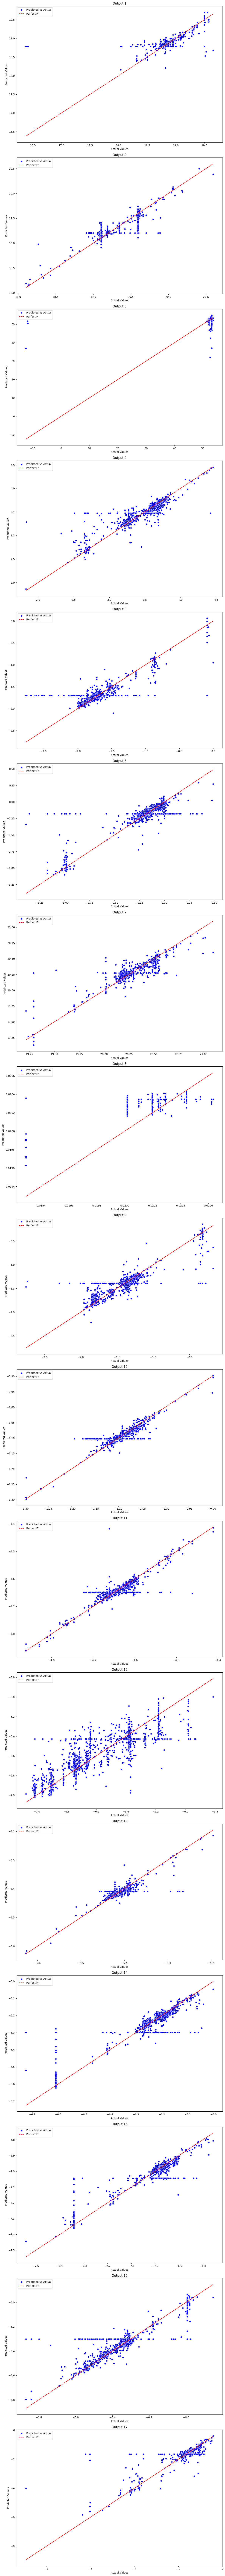

In [109]:
fig, axes = plt.subplots(num_outputs, 1, figsize=(12, 8*num_outputs))

for i in range(num_outputs):
    ax = axes[i] if num_outputs > 1 else axes
    sns.scatterplot(x=y_test[:, i], y=y_pred[:, i], color='blue', label="Predicted vs Actual", ax=ax)
    ax.plot(y_test[:, i], y_test[:, i], color='red', linestyle='dashed', label="Perfect Fit")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"Output {i+1}")
    ax.legend()

plt.tight_layout()
plt.show()